# Loading the data

In [21]:
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df, clipped

def filter_smu_layers(smu_ids, layers):
    # Filter to selected SMU_IDs
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(smu_ids["HWSD2_SMU_ID"])]
    return layers_filtered


mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)


smu_ids, clipped_rds = extract_smu_ids(["Algeria", "Tunisia"])

layers = filter_smu_layers(smu_ids, layers)

layers = layers[layers["LAYER"] == "D1"]
useful_columns = [
    "HWSD2_SMU_ID", "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
layers = layers[useful_columns]
all_cols = layers.drop(columns=["HWSD2_SMU_ID"])
all_cols["TEXTURE_SOTER"] = all_cols["TEXTURE_SOTER"].replace(["-"], np.nan) # replace invalid string entries with NaN
numeric_cols_names = all_cols.select_dtypes(include='number').columns
all_cols[numeric_cols_names] = all_cols[numeric_cols_names].mask(all_cols[numeric_cols_names] < 0, np.nan) # replace invalid negative values with NaN
print(all_cols.describe())
# clipped_rds = clipped_rds.squeeze("band", drop=True)
# clipped_rds.plot(cmap="YlOrBr", robust=True, figsize=(8, 6))
# plt.title("Soil Property Map")
# plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_9080\156320466.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_9080\156320466.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


           COARSE        SAND        SILT        CLAY  TEXTURE_USDA  \
count  841.000000  841.000000  841.000000  841.000000    841.000000   
mean    12.095125   48.092747   30.180737   21.726516      8.971463   
std      9.775966   14.326248    7.655105    9.763214      2.422935   
min      2.000000   13.000000    5.000000    4.000000      3.000000   
25%      4.000000   40.000000   27.000000   16.000000      9.000000   
50%      9.000000   47.000000   30.000000   20.000000      9.000000   
75%     18.000000   55.000000   36.000000   24.000000     11.000000   
max     46.000000   90.000000   53.000000   55.000000     12.000000   

             BULK    REF_BULK  ORG_CARBON    PH_WATER     TOTAL_N  ...  \
count  841.000000  841.000000  841.000000  841.000000  841.000000  ...   
mean     1.429251    1.714614    0.929611    7.700000    0.960190  ...   
std      0.107109    0.131226    0.673056    0.677425    0.435237  ...   
min      0.990000    1.200000    0.242000    4.300000    0.22000

# Analysis part

In [12]:
import math

print(f"Shape {all_cols.shape}")
print("=== Data types per column ===")
print(all_cols.dtypes)

Shape (858, 22)
=== Data types per column ===
COARSE           float64
SAND             float64
SILT             float64
CLAY             float64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL         float64
CEC_CLAY         float64
CEC_EFF          float64
TEB              float64
BSAT             float64
ALUM_SAT         float64
ESP              float64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND        float64
dtype: object


# Missing and erroneous values in each column 

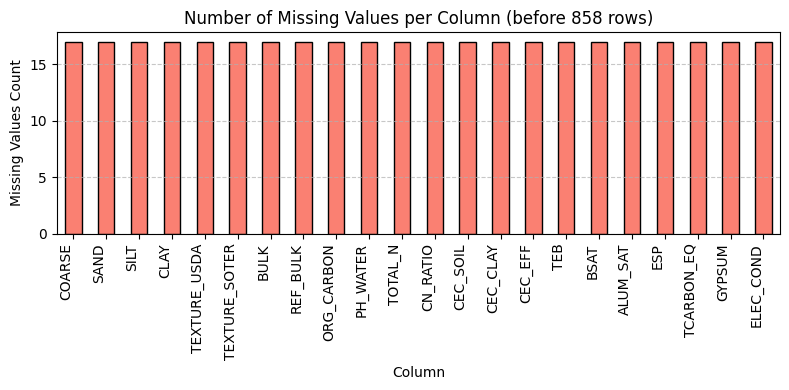

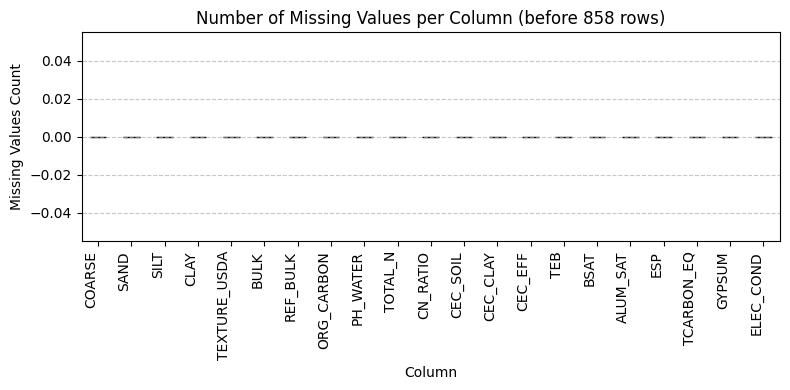

Pandas(Index=79087, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79089, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79093, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79094, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TE

In [22]:

def plot_missing_values(missing_values_count, number_of_rows):
    # number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_count.plot(kind='bar', color='salmon', edgecolor='black')

    plt.title(f"Number of Missing Values per Column (before {number_of_rows} rows)")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

missing_values_count = all_cols.isnull().sum()
plot_missing_values(missing_values_count, all_cols.shape[0])
plot_missing_values((all_cols[numeric_cols_names] < 0).sum(), all_cols.shape[0])
missing_values_rows = all_cols[all_cols.isnull().any(axis=1)]
for row in missing_values_rows.itertuples():
    print(row)


# Fixing Missing values 

C:\Users\pc\AppData\Local\Temp\ipykernel_9080\460826893.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  default_result_row[numeric_cols_names] = all_cols[numeric_cols_names].median()
C:\Users\pc\AppData\Local\Temp\ipykernel_9080\460826893.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  default_result_row[string_cols_names] = all_cols[string_cols_names].mode().iloc[0]


Default row  Pandas(Index=0, COARSE=9.0, SAND=47.0, SILT=30.0, CLAY=20.0, TEXTURE_USDA=9.0, TEXTURE_SOTER='M', BULK=1.440000057220459, REF_BULK=1.7100000381469727, ORG_CARBON=0.6969999670982361, PH_WATER=8.0, TOTAL_N=0.8799999952316284, CN_RATIO=9.0, CEC_SOIL=15.0, CEC_CLAY=61.0, CEC_EFF=31.0, TEB=31.0, BSAT=99.0, ALUM_SAT=0.0, ESP=3.0, TCARBON_EQ=8.899999618530273, GYPSUM=0.6000000238418579, ELEC_COND=1.0)
Found 600 neighbors for index 79087
Pandas(Index=0, COARSE=8.8, SAND=41.8, SILT=35.2, CLAY=23.0, TEXTURE_USDA=8.0, TEXTURE_SOTER='M', BULK=1.5080000162124634, REF_BULK=1.6660000324249267, ORG_CARBON=1.514400029182434, PH_WATER=6.160000038146973, TOTAL_N=1.3079999923706054, CN_RATIO=12.0, CEC_SOIL=17.2, CEC_CLAY=46.4, CEC_EFF=18.6, TEB=17.8, BSAT=74.0, ALUM_SAT=10.6, ESP=1.8, TCARBON_EQ=2.3600000381469726, GYPSUM=0.4800000056624413, ELEC_COND=0.6)
Found 575 neighbors for index 79089
Pandas(Index=0, COARSE=8.8, SAND=41.8, SILT=35.2, CLAY=23.0, TEXTURE_USDA=8.0, TEXTURE_SOTER='M', BULK

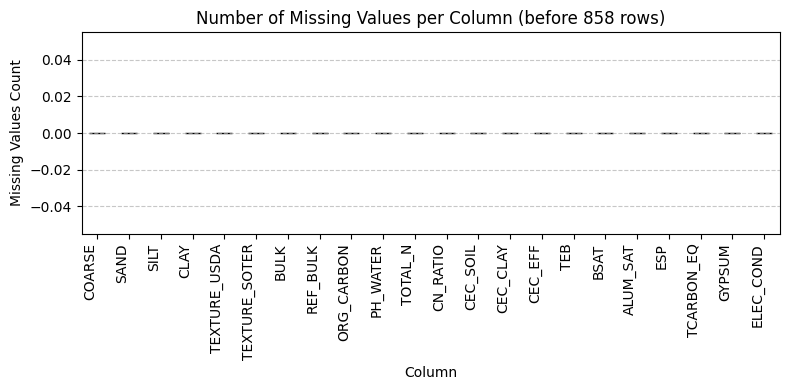

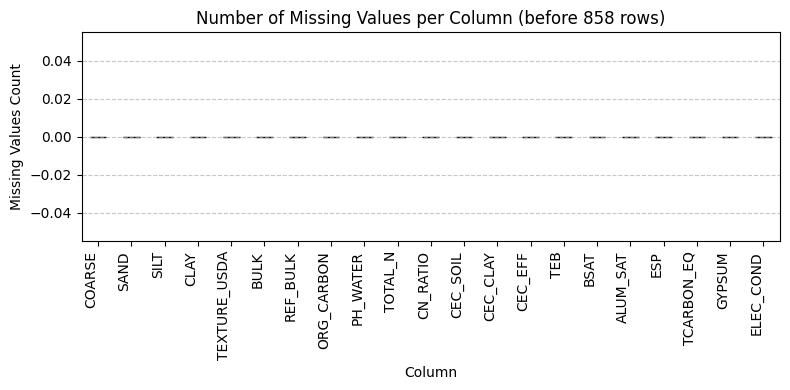

In [29]:
def fix_missing_values(index, defualt_result_row):
    radius = 0.1
    missing_smu_id = smu_ids.loc[index]
    lat_min = missing_smu_id["lat"] - radius
    lat_max = missing_smu_id["lat"] + radius
    lon_min = missing_smu_id["lon"] - radius
    lon_max = missing_smu_id["lon"] + radius

    neighbors_smu_ids = smu_ids[
        (smu_ids["lat"] >= lat_min) & (smu_ids["lat"] <= lat_max) &
        (smu_ids["lon"] >= lon_min) & (smu_ids["lon"] <= lon_max)
    ]
    print(f"Found {len(neighbors_smu_ids)} neighbors for index {index}")

    neighbors_layers = layers[
        layers["HWSD2_SMU_ID"].isin(neighbors_smu_ids["HWSD2_SMU_ID"]) &
        (layers.index != index)  # exclude the row itself
    ].drop(columns=["HWSD2_SMU_ID"])

    if neighbors_layers.empty:
        return default_result_row

    numeric_cols = neighbors_layers.select_dtypes(include=['number']).mean().to_frame().T
    default_numeric_cols = default_result_row.select_dtypes(include=['number'])
    numeric_cols[numeric_cols < 0] = default_numeric_cols[numeric_cols < 0]

    string_cols = neighbors_layers.select_dtypes(include=['object']).mode().iloc[0].to_frame().T
    
    result_row = pd.concat([numeric_cols, string_cols], axis=1)[neighbors_layers.columns]
    
    return result_row

missing_values_indices = missing_values_rows.index

default_result_row = pd.DataFrame([ [np.nan]*len(all_cols.columns) ], columns=all_cols.columns)
numeric_cols_names = all_cols.select_dtypes(include='number').columns
string_cols_names = all_cols.select_dtypes(include='object').columns
default_result_row[numeric_cols_names] = all_cols[numeric_cols_names].median()
default_result_row[string_cols_names] = all_cols[string_cols_names].mode().iloc[0]
print("Default row ", next(default_result_row.itertuples()))

for i, index in enumerate(missing_values_indices):
    result_row = fix_missing_values(index, default_result_row)
    print(next(result_row.itertuples()))
    all_cols.loc[index] = result_row.iloc[0]
# print(all_cols.isnull().sum())

missing_values_count = all_cols.isnull().sum()
plot_missing_values(missing_values_count, all_cols.shape[0])
plot_missing_values((all_cols[numeric_cols_names] < 0).sum(), all_cols.shape[0])

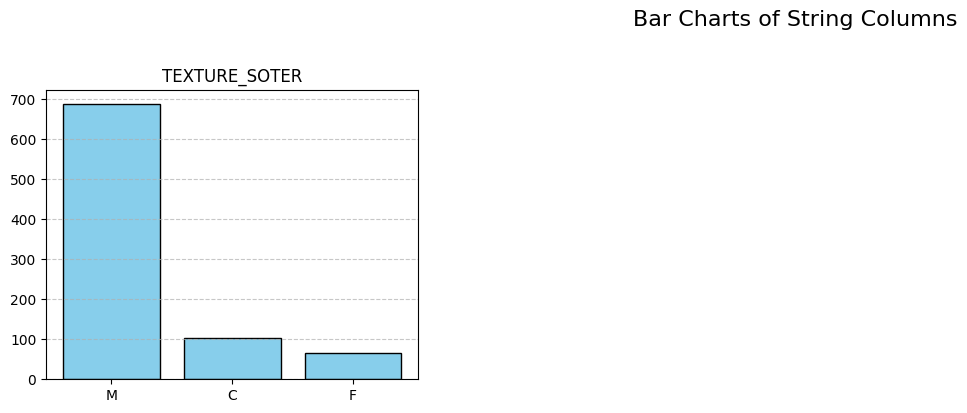

In [6]:
string_cols = all_cols.select_dtypes(include=['object'])
# plot bar charts for categorical columns
cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_bar_charts(string_cols):
    n = len(string_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Bar Charts of String Columns", fontsize=16, y=1.02)
    for i, col in enumerate(string_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        value_counts = string_cols[col].value_counts()
        plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_bar_charts(string_cols)


# Univariate Analysis

In [31]:
numeric_cols = all_cols[numeric_cols_names]
stats_table = numeric_cols.describe().T.round(2)  # Transpose for better readability

# Print the table
print(stats_table)

# Save to CSV
stats_table.to_csv("../images/soil/numeric_columns_statistics.csv")


              count   mean    std    min    25%    50%     75%     max
COARSE        858.0  12.08   9.69   2.00   4.00   9.00   18.00   46.00
SAND          858.0  47.95  14.23  13.00  40.42  47.00   55.00   90.00
SILT          858.0  30.22   7.60   5.00  27.00  30.00   36.00   53.00
CLAY          858.0  21.74   9.67   4.00  16.00  20.00   24.00   55.00
TEXTURE_USDA  858.0   8.95   2.40   3.00   9.00   9.00   11.00   12.00
BULK          858.0   1.43   0.12   0.12   1.37   1.44    1.48    1.76
REF_BULK      858.0   1.71   0.13   1.20   1.65   1.71    1.78    2.04
ORG_CARBON    858.0   0.93   0.67   0.24   0.59   0.70    1.16    7.33
PH_WATER      858.0   7.68   0.70   3.66   7.40   8.00    8.20    8.60
TOTAL_N       858.0   0.96   0.43   0.22   0.73   0.88    1.12    3.69
CN_RATIO      858.0   9.98   1.52   7.40   9.00   9.00   10.00   24.00
CEC_SOIL      858.0  15.75   7.11   4.00  13.00  15.00   17.00   41.00
CEC_CLAY      858.0  59.29  14.67  16.00  48.00  61.00   71.00   83.00
CEC_EF

# Unique numeric values in integer column 

In [ ]:

int_cols = numeric_cols.select_dtypes(include="int")
unique_values = int_cols.nunique().sort_values(ascending=False)
if (unique_values.empty):
    print("No integer columns with unique values found.")
else:
    plt.figure(figsize=(8,4))
    unique_values.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f"Number of Unique Values per Integer Column (in {all_cols.shape[0]} rows)")
    plt.ylabel("Count of Unique Values")
    plt.xlabel("Column")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


No integer columns with unique values found.


# Value distribution and outliers for numeric columns

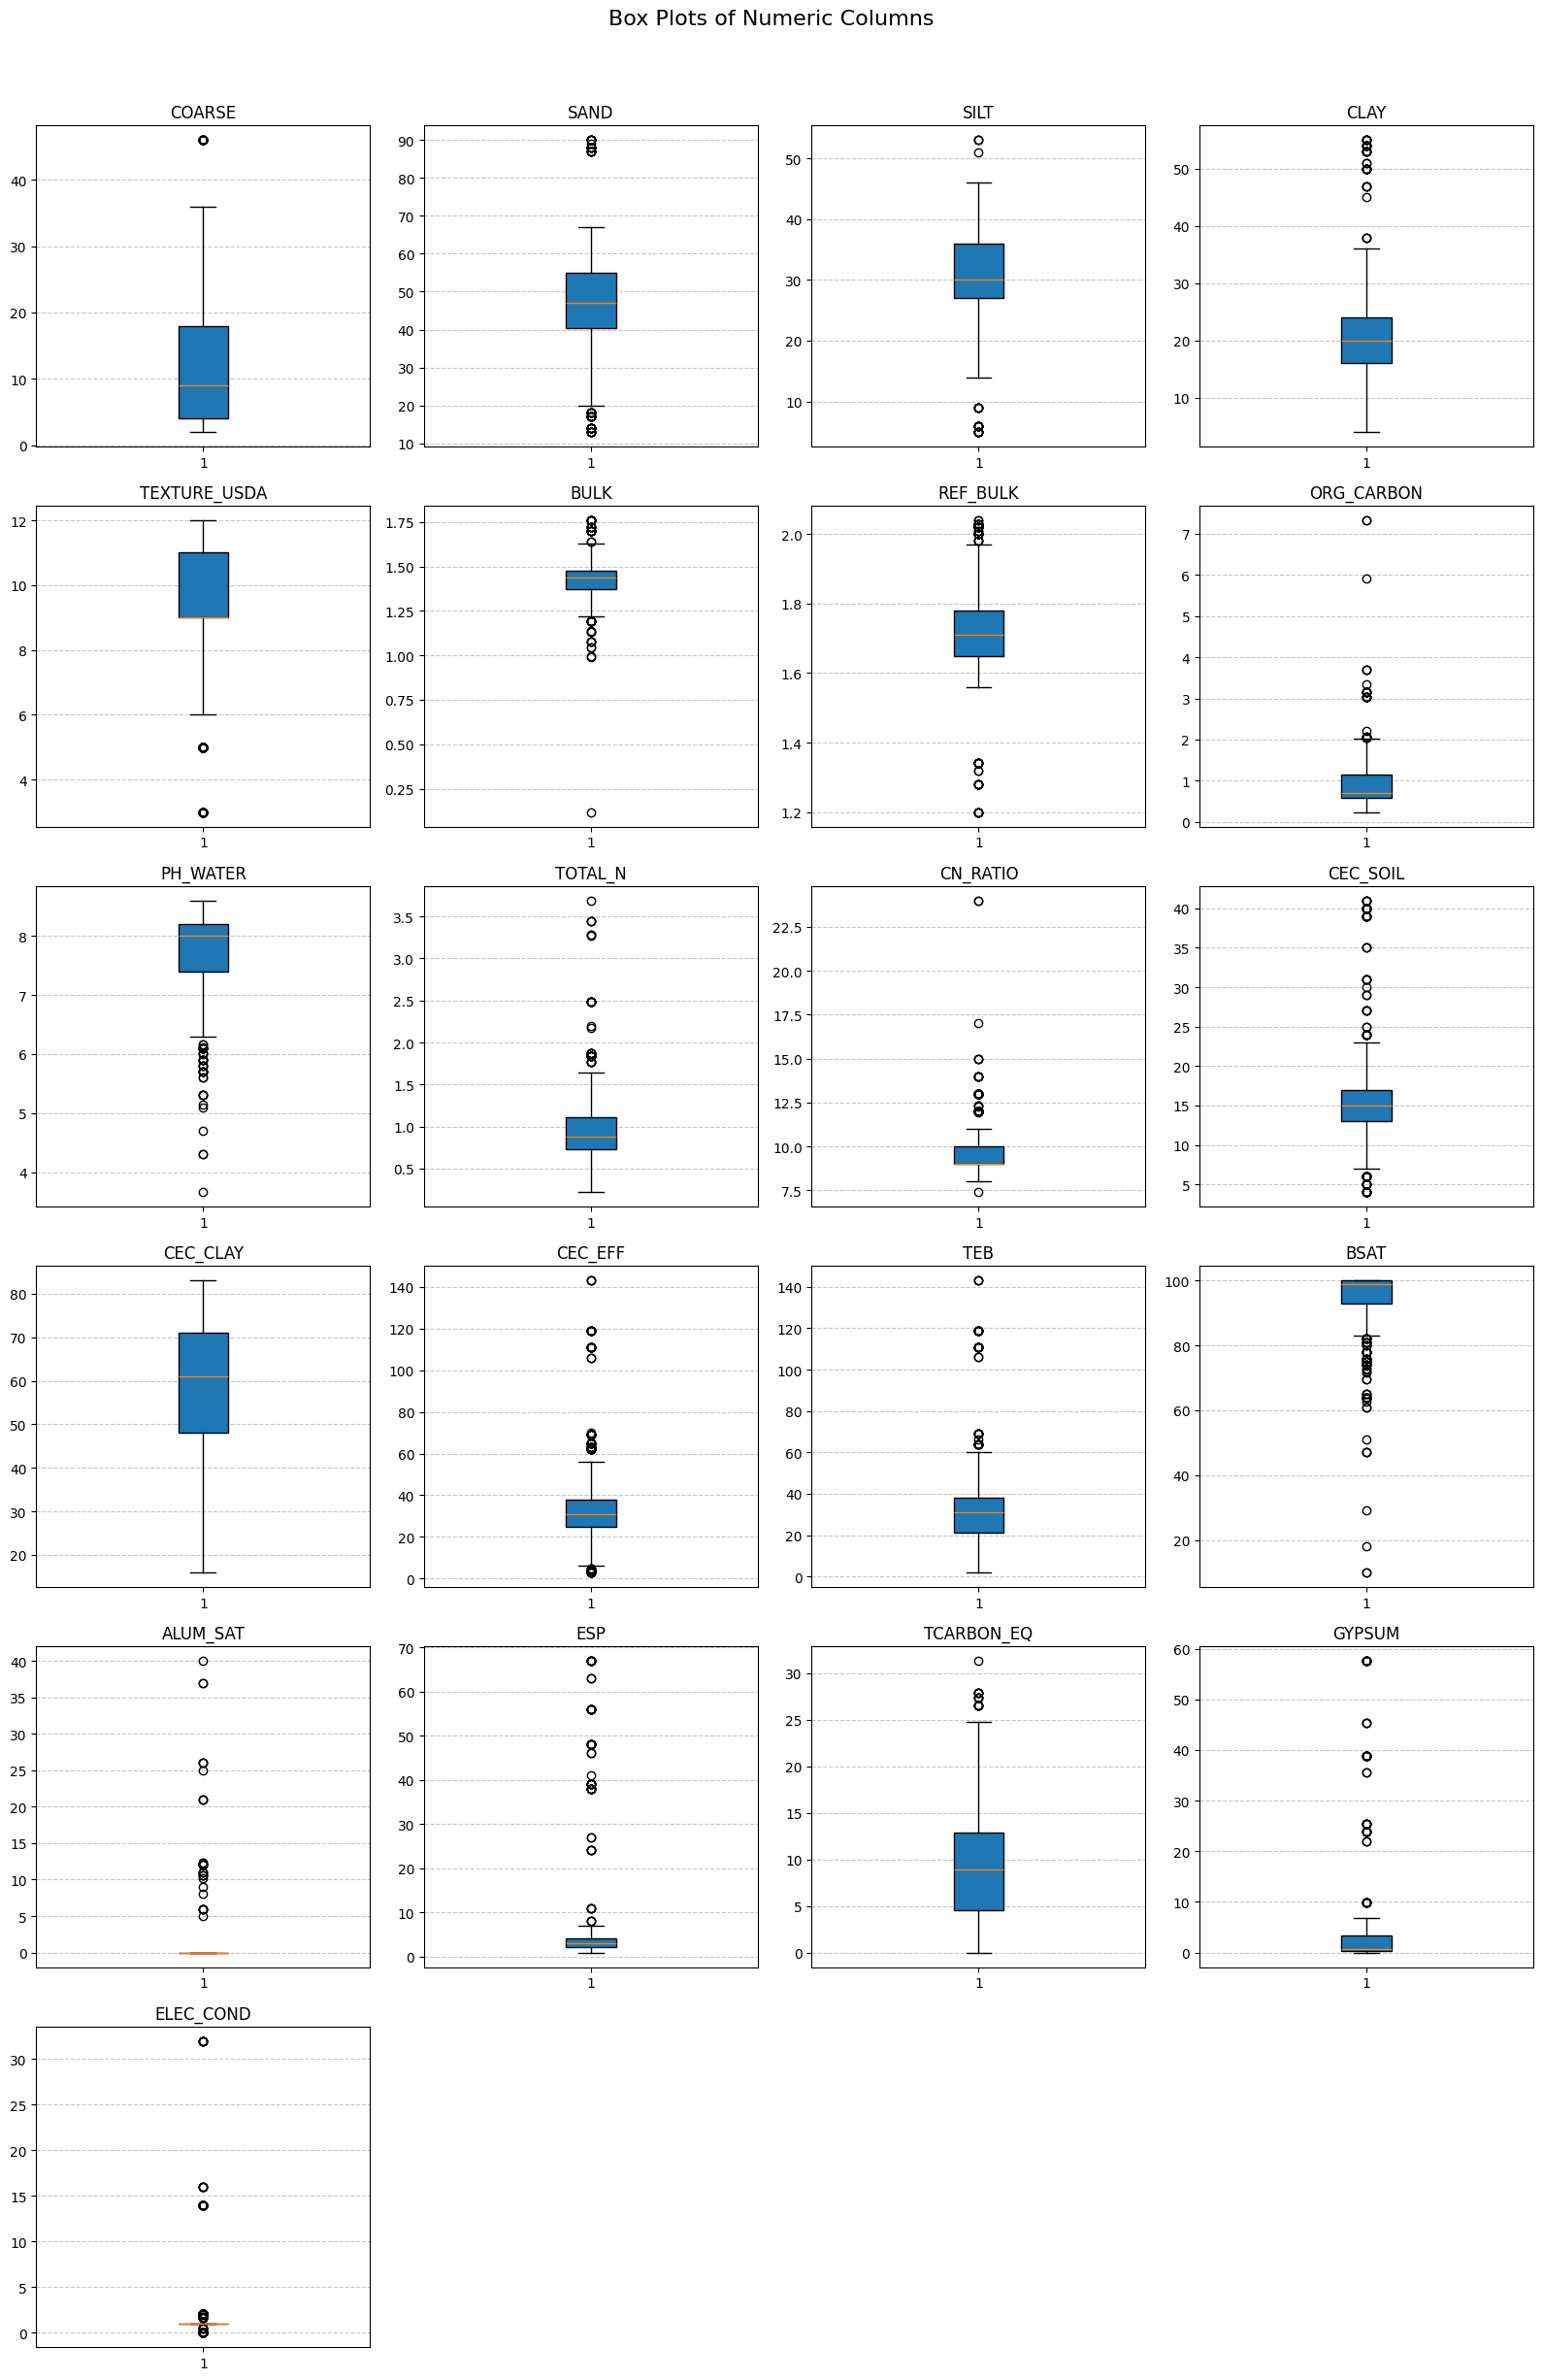

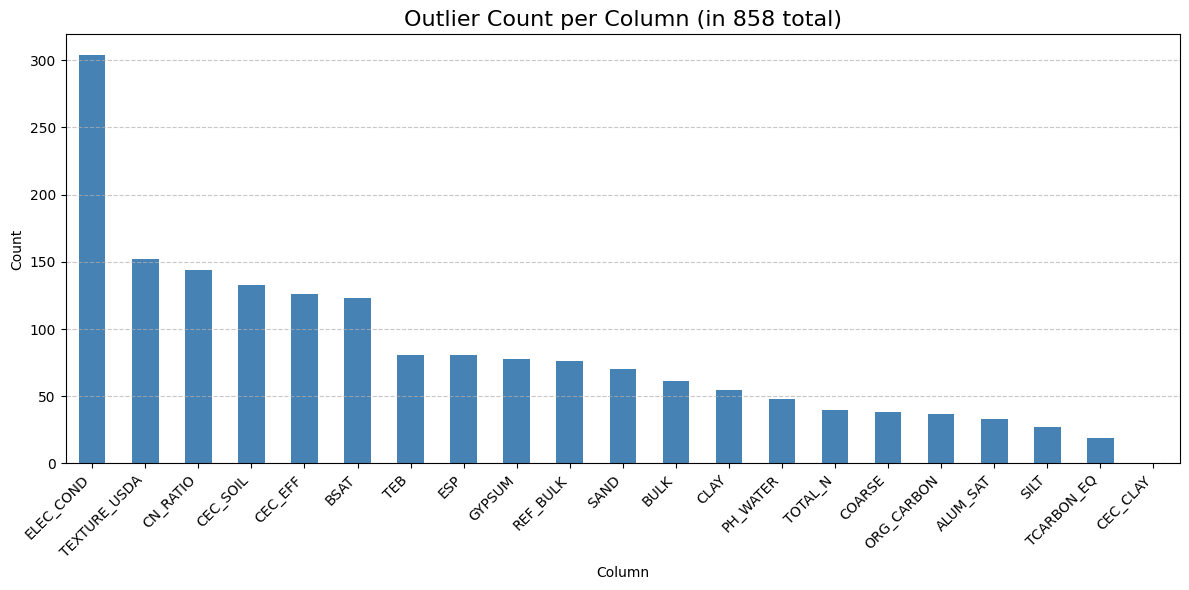

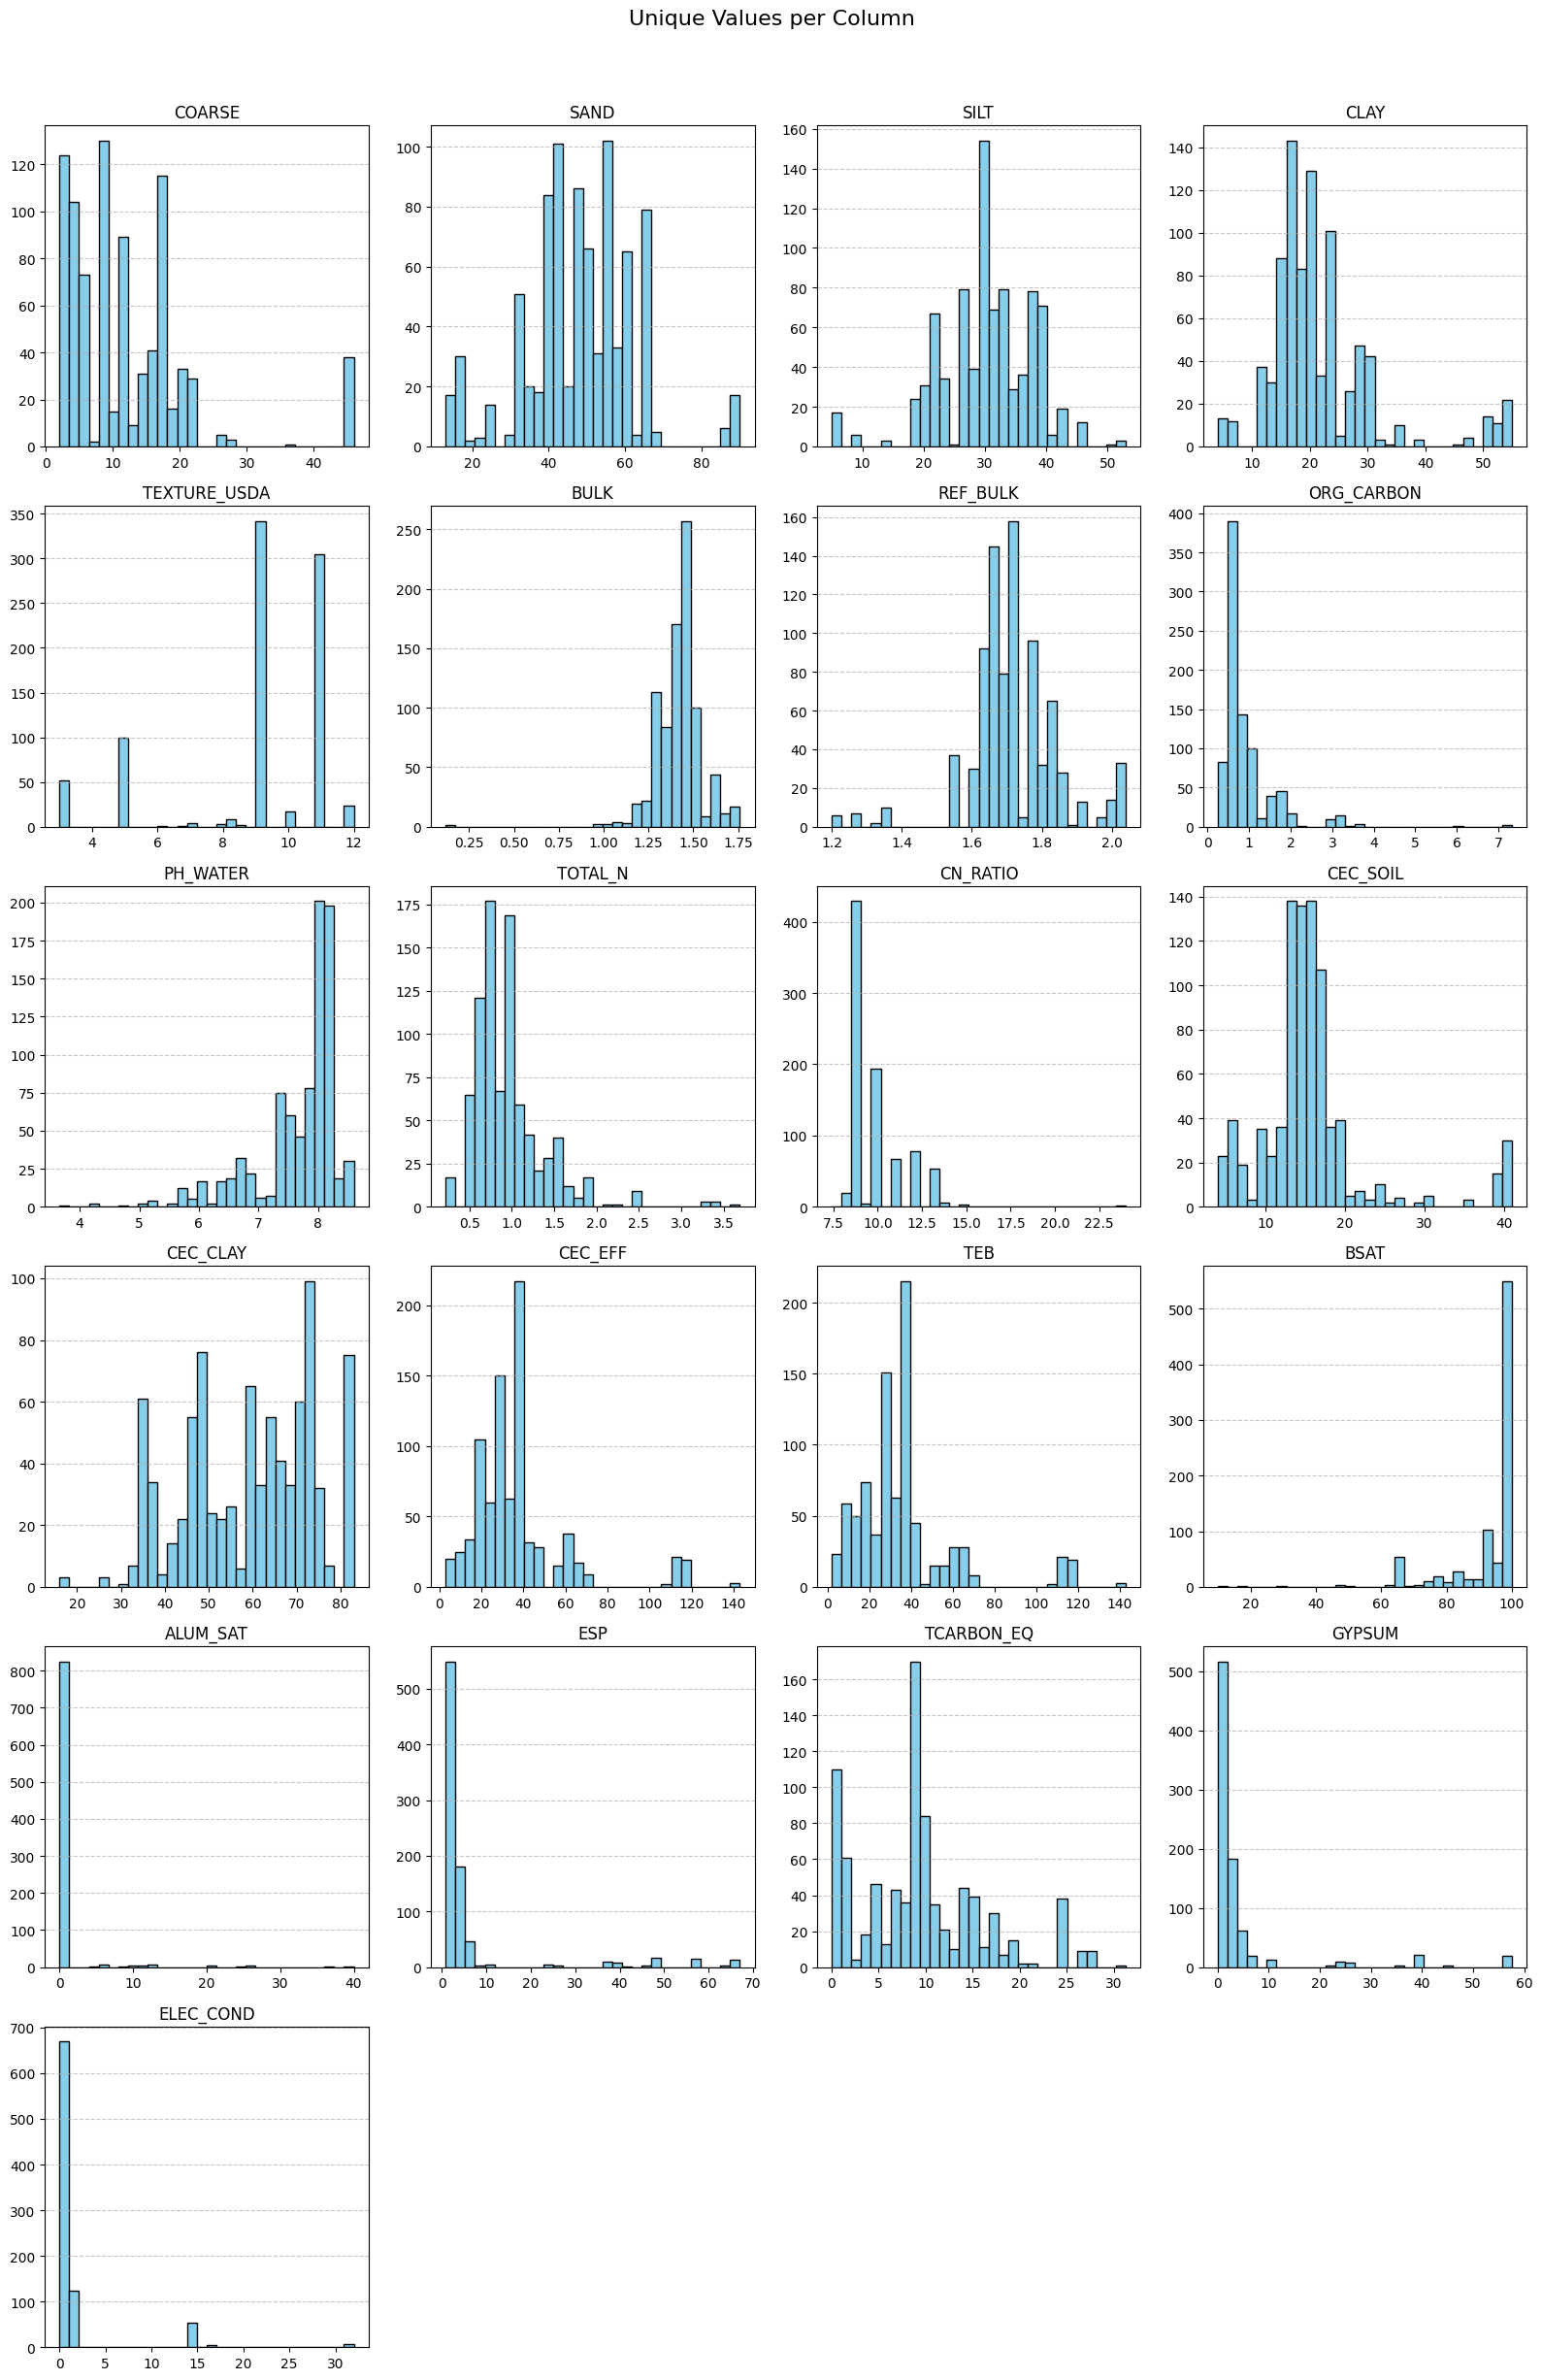

In [32]:

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_box_plots(numeric_cols)





Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



plot_histograms(numeric_cols)

# Fixing Outliers and negative values

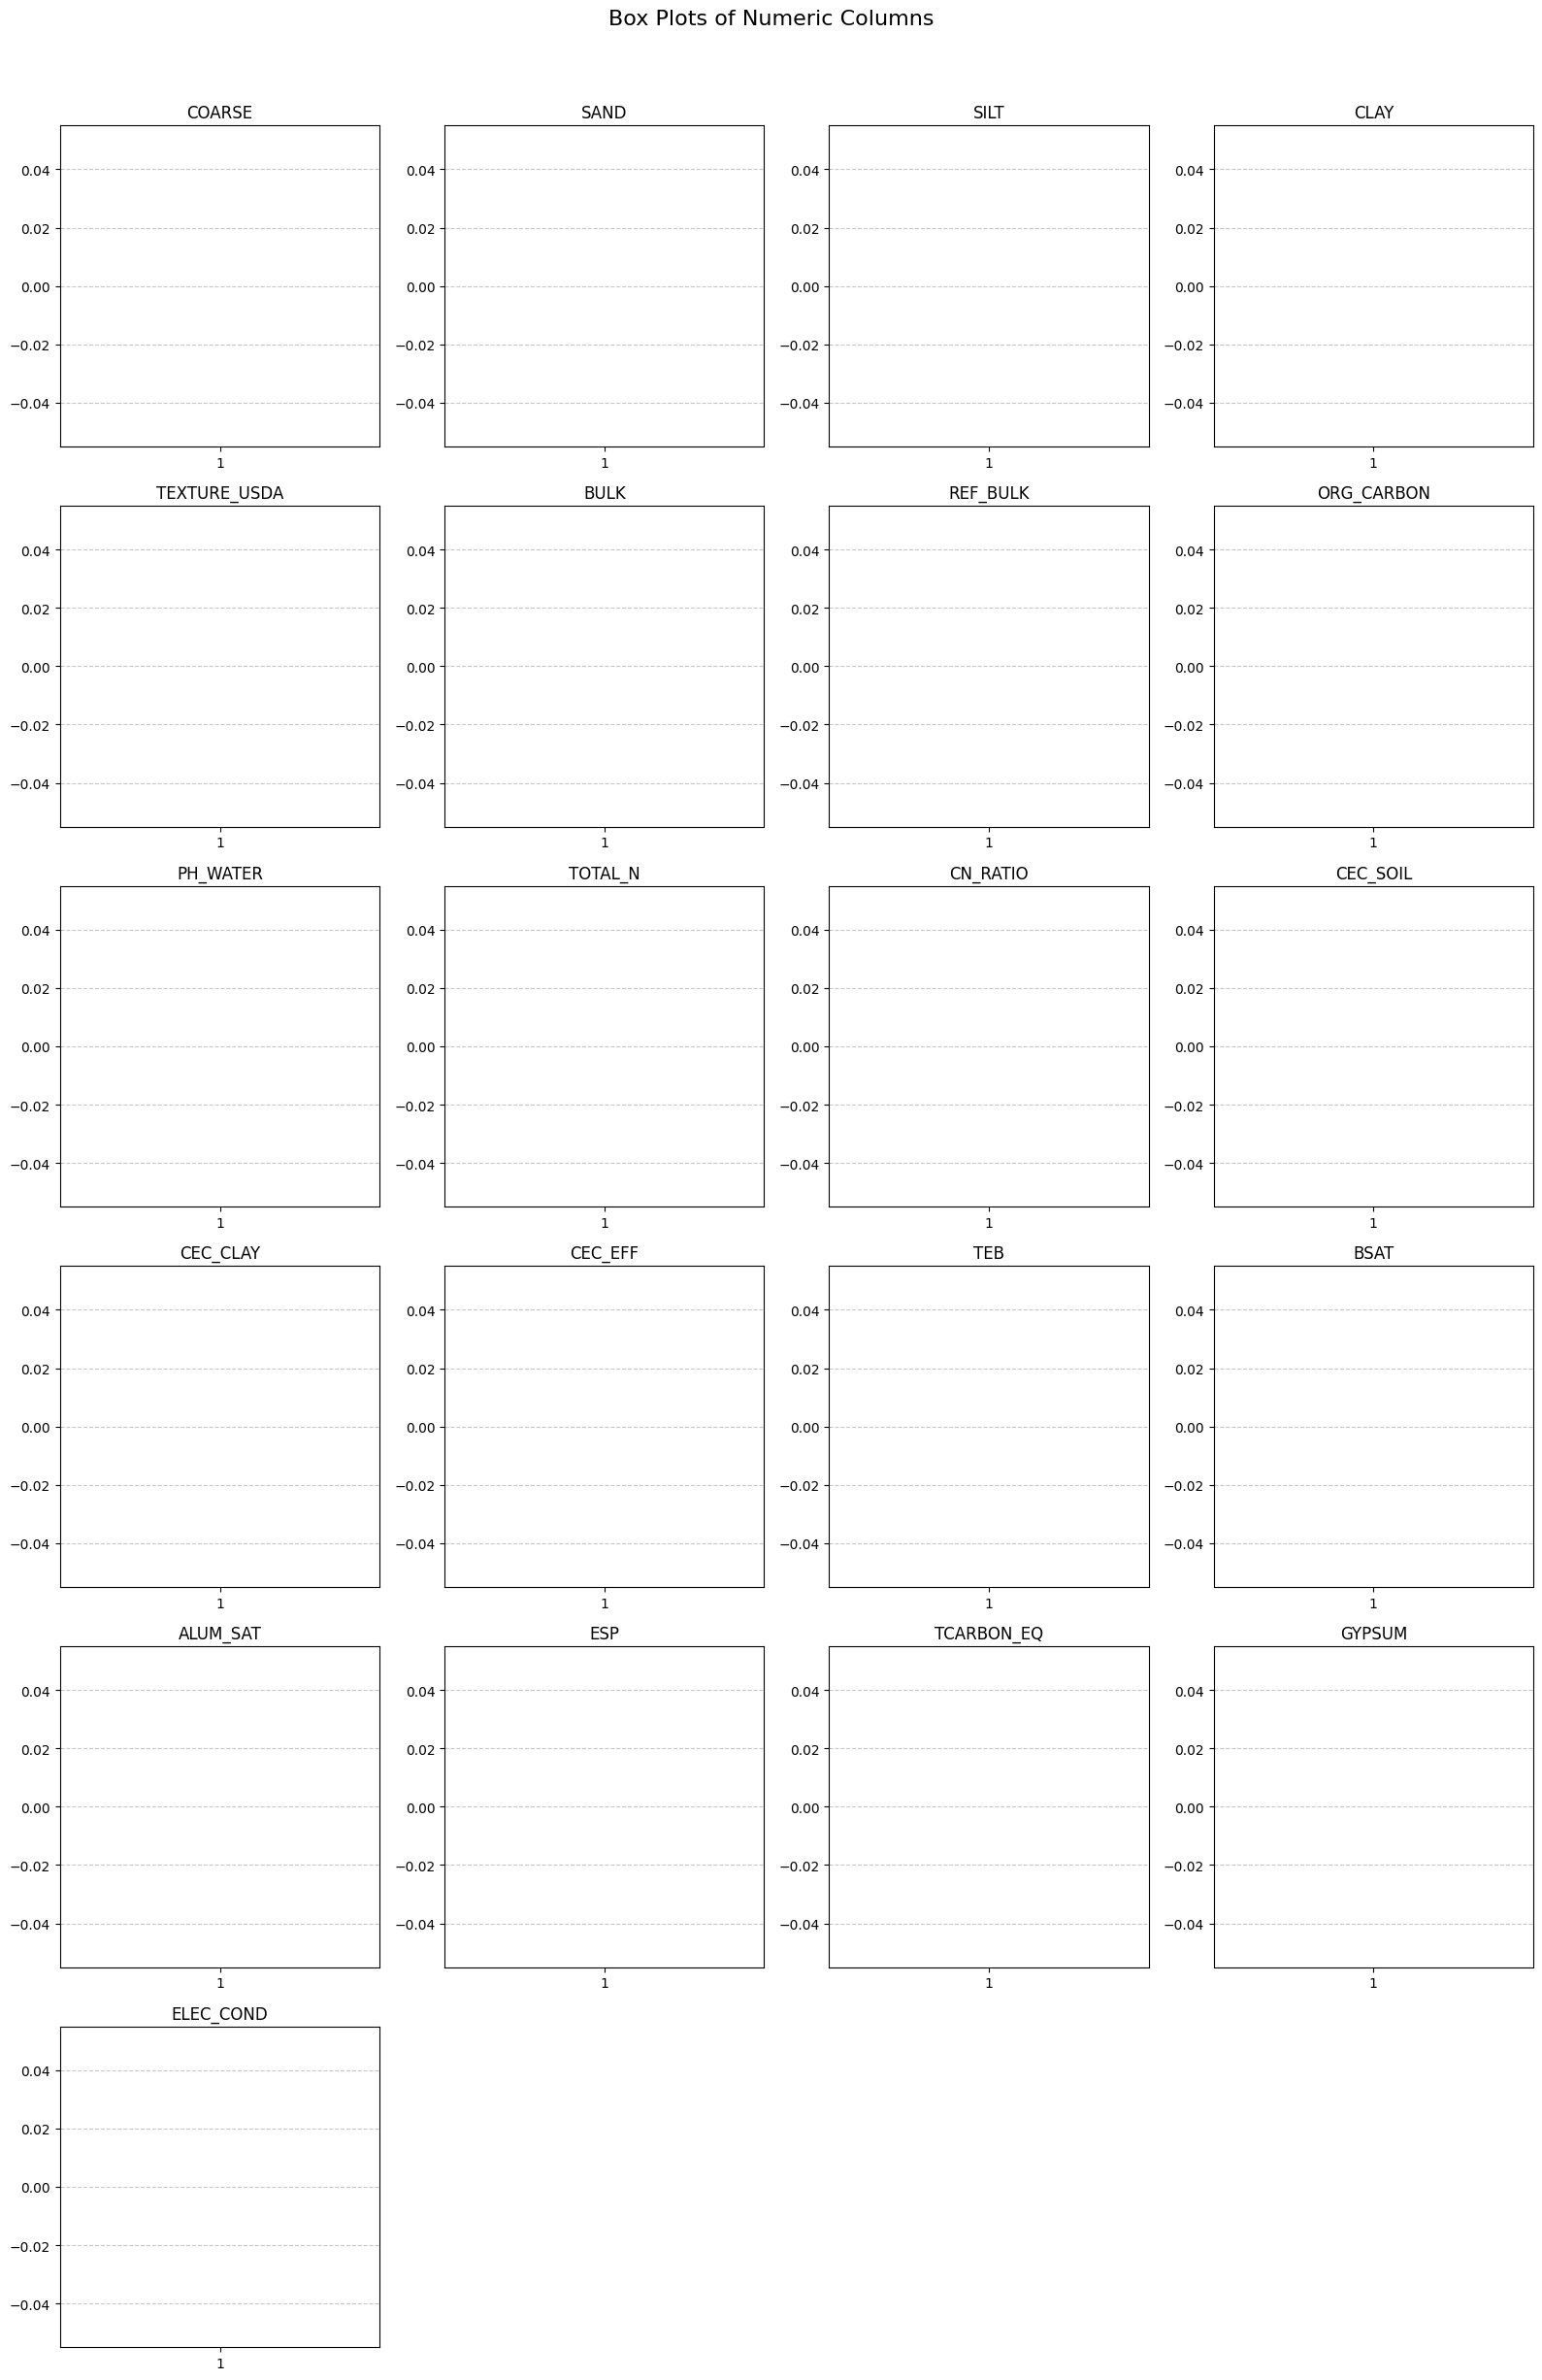

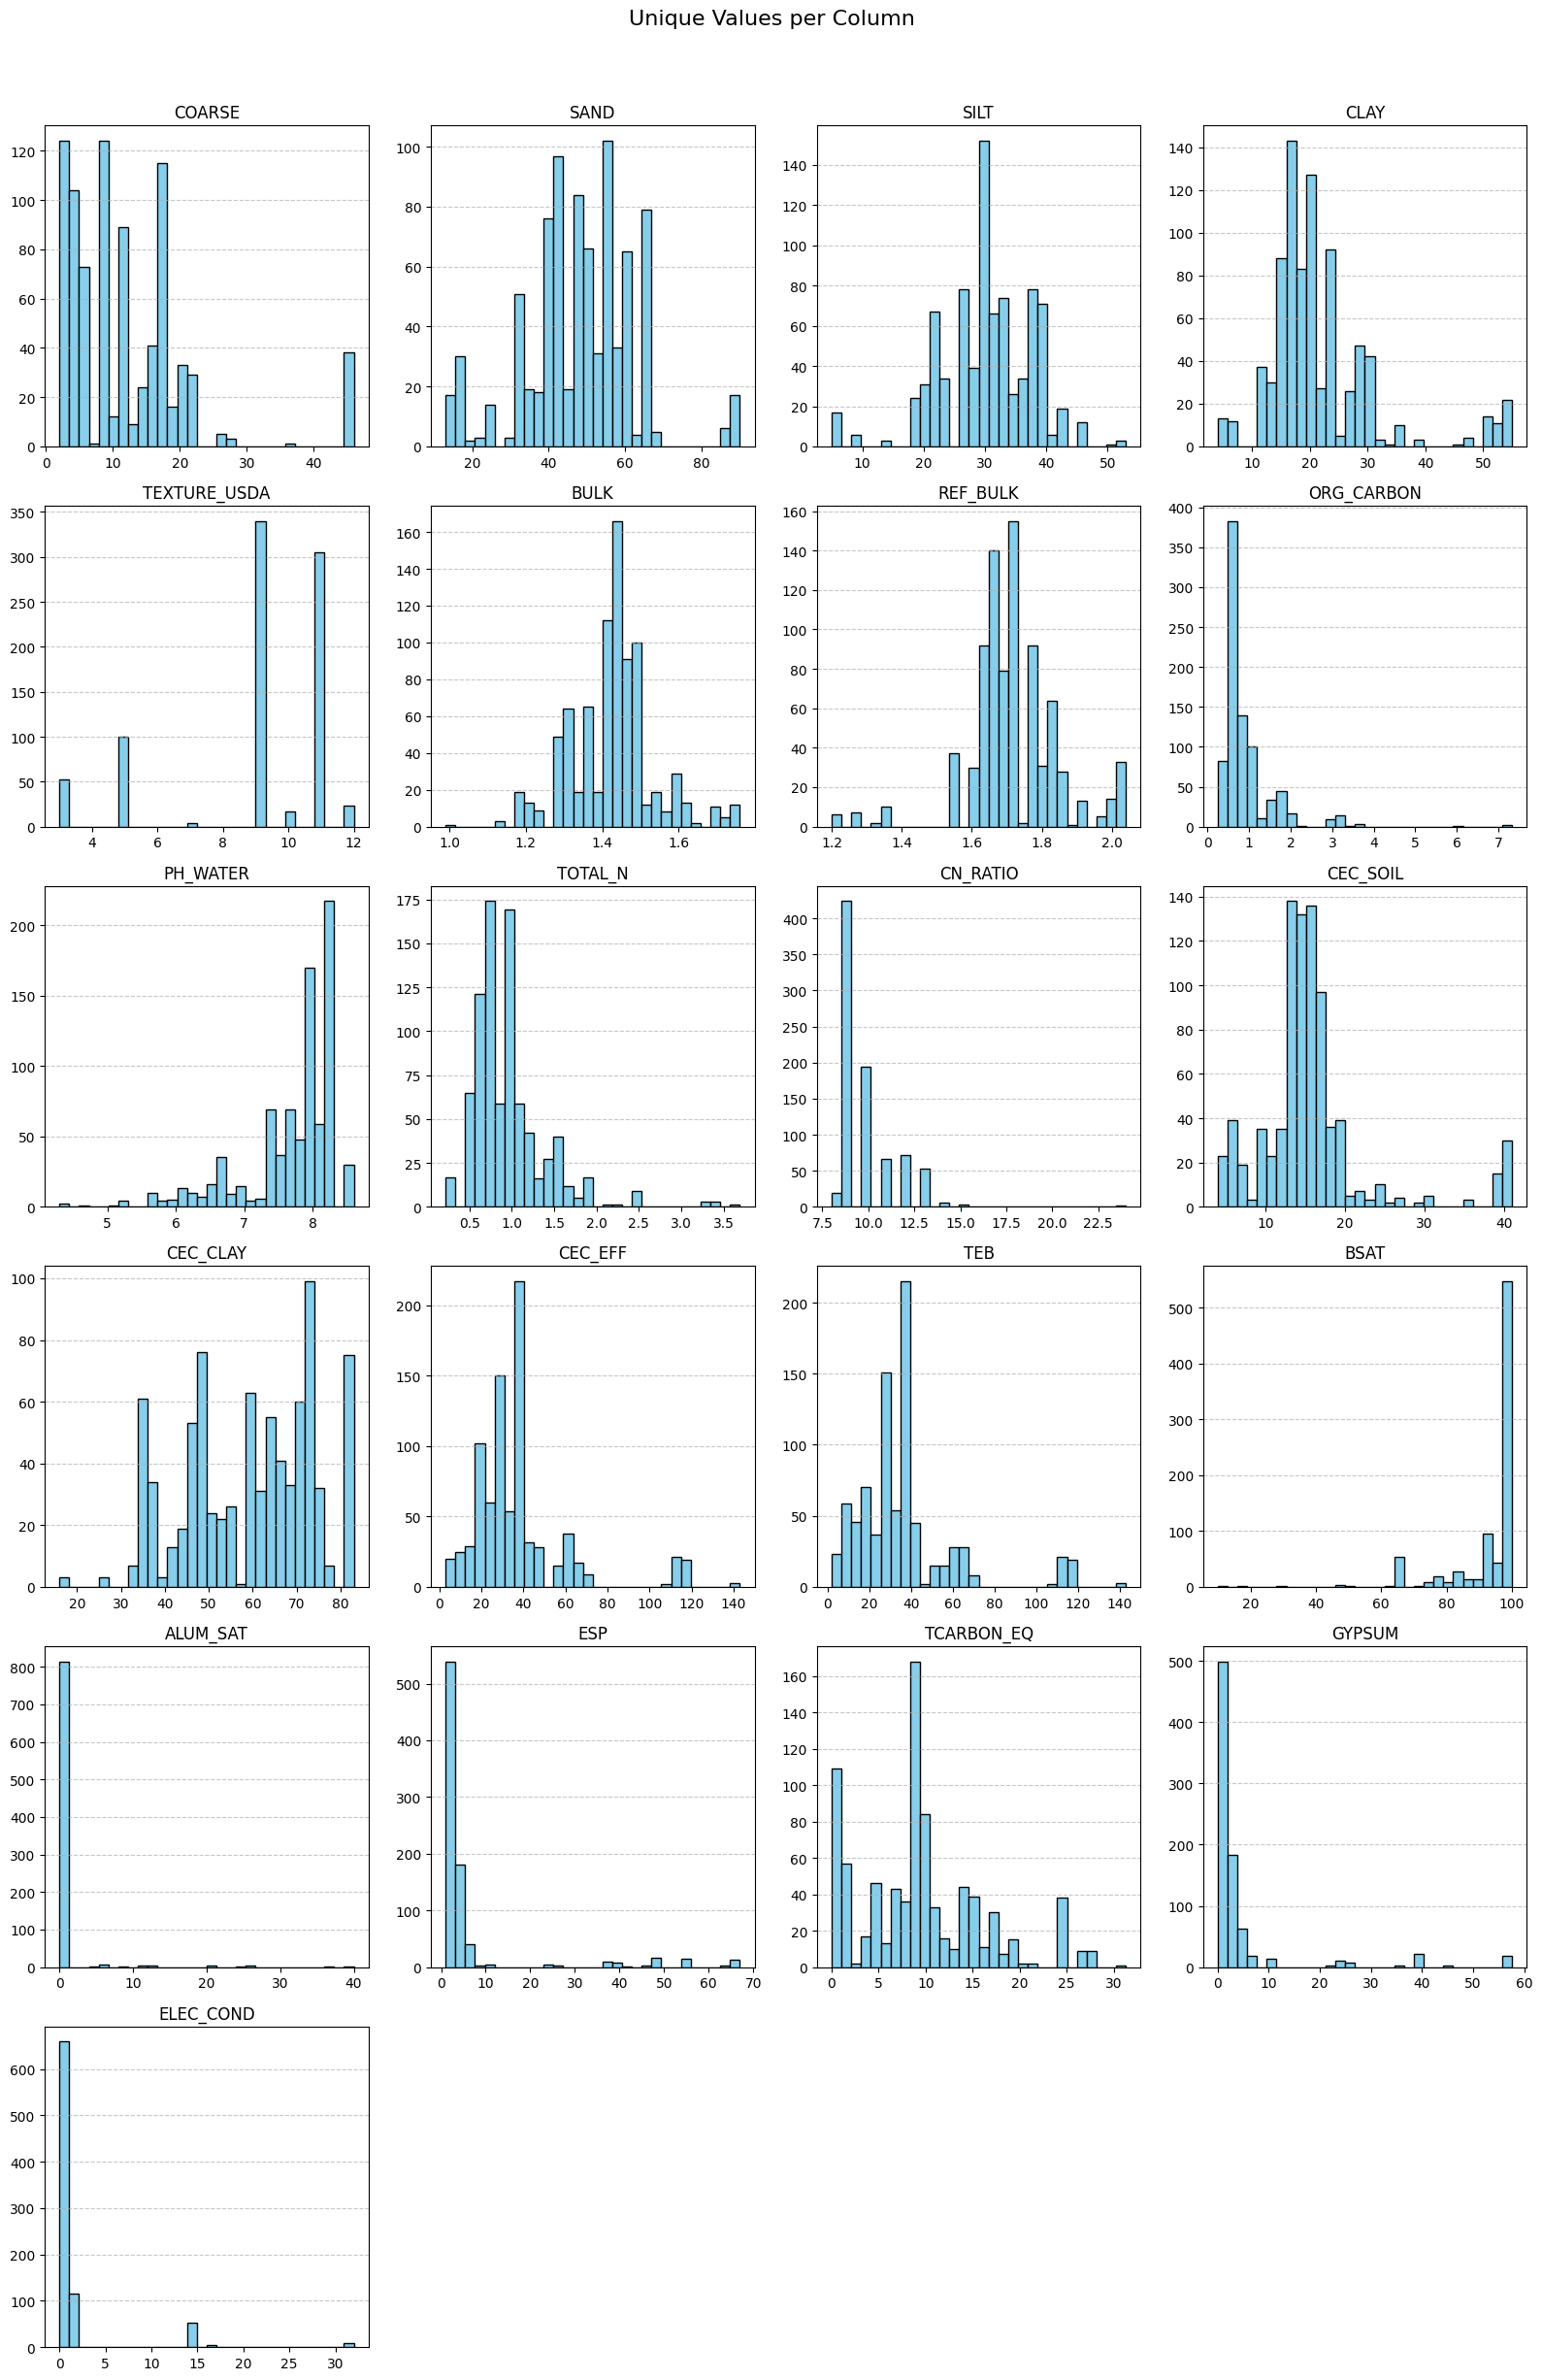

In [ ]:
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# numeric_cols = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)

plot_box_plots(numeric_cols)
plot_histograms(numeric_cols)


# Correlation analysis

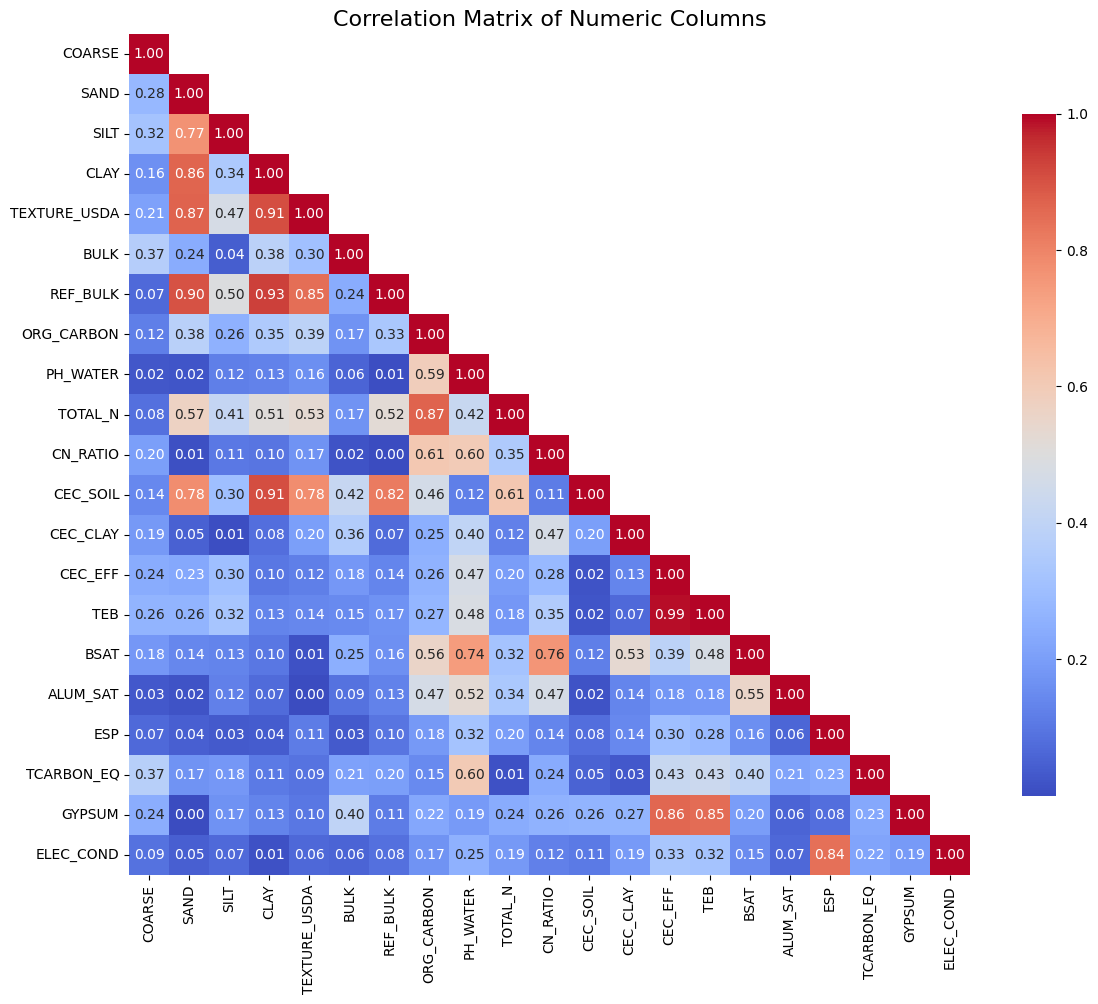

In [ ]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

# Remove Correleated Features 

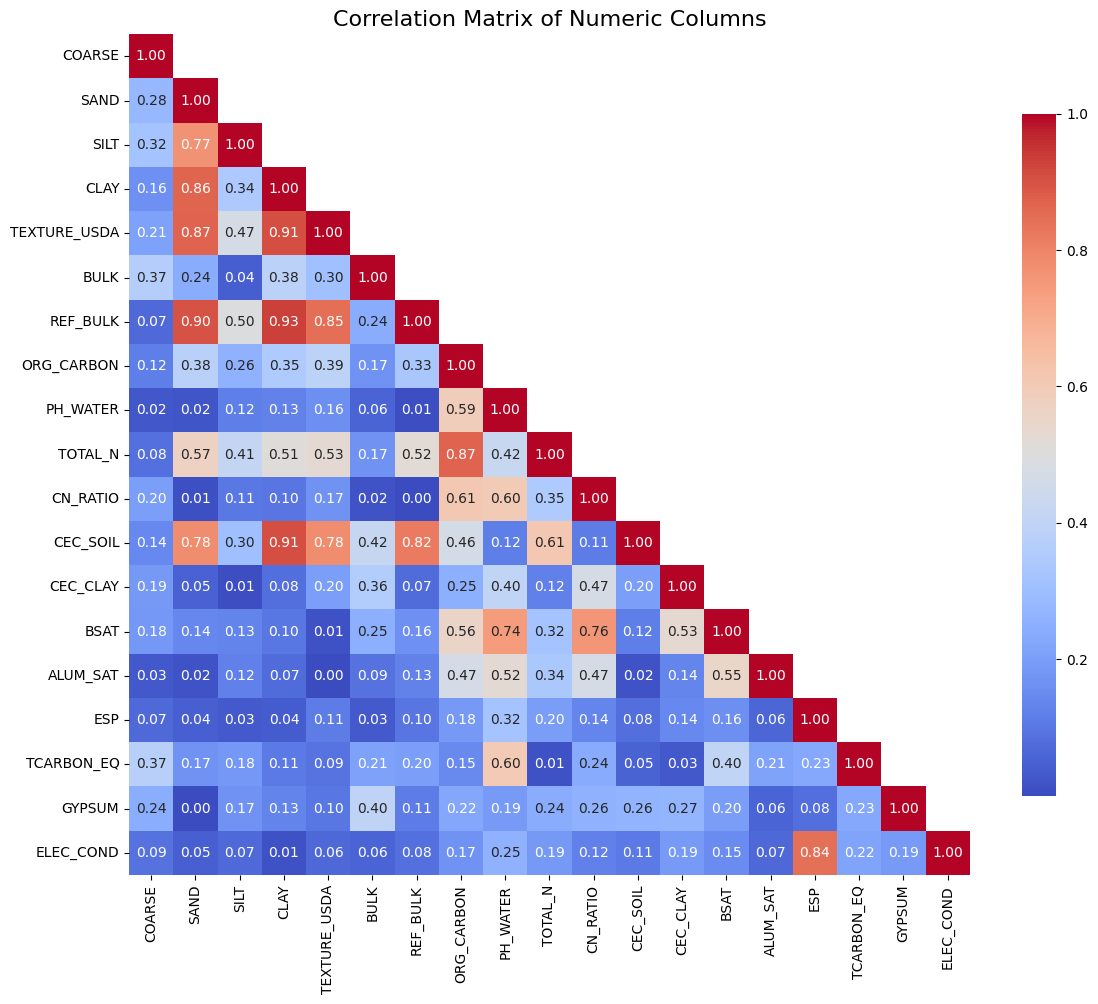

In [ ]:
np.fill_diagonal(correlation_matrix.values, 0)
correlated_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.95 )]
new_numeric_cols = numeric_cols.drop(columns=correlated_cols)
plot_correlation_matrix(new_numeric_cols.corr().abs())

# Remerging all columns

In [ ]:
all_cols.update(new_numeric_cols)


# Exporting cleaned dataset

In [96]:

# =========================
# ======= EXPORTING =======
# =========================

layers.update(all_cols)
dataset = smu_ids.merge(layers, on="HWSD2_SMU_ID", how="inner")
dataset = dataset.drop(columns=["HWSD2_SMU_ID"])
print("Merging complete.")

dataset.to_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet", index=False)
print("Parquet export complete.")

# xarray_dataset_full = xarray.Dataset.from_dataframe(dataset)
# xarray_dataset_full.to_netcdf(r"../local_dataset/dataset/soil_full.nc")
# # print("NetCDF export complete.")

# nc_layers_full = xarray.open_dataset(r"../local_dataset/dataset/soil_full.nc")
# dataset = nc_layers_full.to_dataframe().reset_index(drop=True)

# print(dataset.shape)
# dataset.describe()





C:\Users\pc\AppData\Local\Temp\ipykernel_10340\696494103.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.         11.         11.          7.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          6.          6.          6.          6.          6.
  6.          6.          9.          9.          9.          9.
  9.          9.         11.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 11.         11.         11.         11.         11.         11.
 11.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.         26.
 26.         26.         26.         26

Merging complete.
Parquet export complete.


# Checking the data after export

In [97]:
dataset = pd.read_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet")

print("=== Checking the data after export === ")
print("=== Shape === ")
print(dataset.shape)
print("=== Missing Values === ")
print(dataset.isnull().sum())

=== Checking the data after export === 
=== Shape === 
(7109938, 24)
=== Missing Values === 
lon              0
lat              0
COARSE           0
SAND             0
SILT             0
CLAY             0
TEXTURE_USDA     0
TEXTURE_SOTER    0
BULK             0
REF_BULK         0
ORG_CARBON       0
PH_WATER         0
TOTAL_N          0
CN_RATIO         0
CEC_SOIL         0
CEC_CLAY         0
CEC_EFF          0
TEB              0
BSAT             0
ALUM_SAT         0
ESP              0
TCARBON_EQ       0
GYPSUM           0
ELEC_COND        0
dtype: int64
